In [3]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

# MBTI 별 posting 모으기

In [4]:
mbti=pd.read_csv('./data/mbti_1.csv')

types = mbti.groupby('type').count()

output_file = '.\data\\training\\mbti.csv' # raw string이 아니라 '\'를 쓰려면 \\라고 해야 함
allData = []

for type in types.index:
    condition = mbti['type'] == type # condition: mbti['type']가 topfive의 원소인 type 같을 bool 조건
    ownsentence = mbti[condition]  # ownsentence: condition에 맞는 row만 filtering한 dataframe
    allData.append(ownsentence)
dataCombine = pd.concat(allData, axis=0, ignore_index=True)
dataCombine.to_csv(output_file, index=False)

types

    #input_file = r'.\data\training'
    #allFile_list = glob.glob(os.path.join(input_file, 'mbti_*'))
    #for file in allFile_list:
    #    csv = pd.read_csv(file,sep=';', encoding='iso-8859-1') # for구문으로 csv파일들을 읽어 들인다
    #    cleanMbti = csv['posts'].str.replace('[^A-Za-z\s]+', '')

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


# Resampling (Undersampling and Oversampling)

# Tokenize and Stemming
morph analysis 기법.

In [5]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
mbti= dataCombine
X_data = mbti['posts']
y_data = mbti['type']

type(X_data)

normalized_text = []
for sentence in X_data.tolist():
    clean_sentence = re.sub('[^A-Za-z\s]+', '',sentence.lower())    # posts 데이터 정규화()
    normalized_text.append(clean_sentence)
mbti.posts = normalized_text

TypeError: 'str' object is not callable

In [12]:
ps=PorterStemmer()

# print("stopwords 제거 시작")
stopwords = ['http*']
#print("stopwords 제거 완료")

stemData=[] # stemmed X_data: mbti['posts']
tokenizedData=[]    # tokenized X_data
for sentence in mbti['posts']:
    tokenData = nltk.word_tokenize(sentence)
    tempData = []   # 개별 post
    for word in tokenData:
        tempData.append(ps.stem(word))
        #tempData = [word for word in tempData if not word in stopwords] # 불용어 제거
    tokenizedData.append(tokenData)
    stemData.append(tempData)
#print(stemData[0])

#'list' object has no attribute 'lower' 문제 발생
# 2차원 리스트인 stemData를 1차원 리스트로
#flat_stem = [item for sublist in stemData for item in sublist]

# Data 확인
실제 data와 stemmed Data의 양상이 일치하는지 확인. 확인 결과 한 post의 길이가 지나치게 적은 곳이 있었지만, 결과에 유의미하게 부정적인 영향을 미치지 않는다고 판단해서 정제하지 않기로 했다.

post의 최대 길이(단어 수) :1875
post의 최소 길이 :2
post의 평균 길이 :1212.967492795389
post의 전체 길이 :10522493
post의 갯수: 8675
첫 post의 단어 개수:791


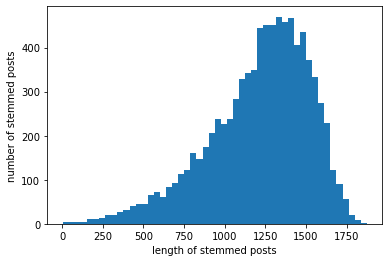

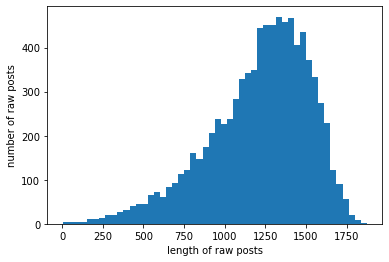

In [22]:
bagoftoken = tokenizedData.flatten()
bagofstemmed = stemData.flatten()

print('post의 최대 길이(단어 수) :{}'.format(max(len(l) for l in stemData)))
print('post의 최소 길이 :{}'.format(min(len(l) for l in stemData)))
print('post의 평균 길이 :{}'.format(sum(map(len, stemData))/len(stemData)))
print('post의 전체 길이 :{}'.format(sum(map(len, stemData))))
print('post의 갯수: {}'.format(len(stemData)))
print('첫 post의 단어 개수:{}'.format(len(stemData[0])))

plt.hist([len(s) for s in stemData], bins=50)
plt.xlabel('length of stemmed posts')
plt.ylabel('number of stemmed posts')
plt.show()

plt.hist([len(s) for s in tokenizedData], bins=50)
plt.xlabel('length of raw posts')
plt.ylabel('number of raw posts')
plt.show()

# Vectorization(tfidf)
padding 과정이 따로 필요하지 않은 output이 나와서 padding 생략

In [38]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def dummy_fun(doc):
    return doc

tfidf=TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None
)

X = tfidf.fit_transform(stemData).toarray()

print(y_data)
y = np.array(y_data)
print(y)
# le = LabelEncoder() # string인 'type' label을 int로 바꿔준다 (input: array)
# y = le.fit_transform(y).reshape(-1,1)
# y = to_categorical(y)
'''tf = TfidfVectorizer().fit(stemData)
print(tf.transform(stemData).toarray())
print(tf.vocabulary_)
#print(vector.vocabulary_)'''

MemoryError: Unable to allocate 19.1 GiB for an array with shape (8675, 295647) and data type float64

# Model building

In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1234)
model = XGBClassifier()
model.fit(X_train, y_train)
preds = classifier.predict(X_test)

ValueError: bad input shape (6072, 16)

In [ ]:
from sklearn.externals import joblib

joblib.dump(model, 'XGBoost_rawsample.pkl') 

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from yellowbrick.classifier import ROCAUC

# labels과 guesses
labels = preds
guesses = y_test

print(accuracy_score(labels, guesses))
print(recall_score(labels, guesses))
print(precision_score(labels, guesses))
print(f1_score(labels, guesses))

visualizer = ROCAUC(xgb_basic, classes=[0, 1], micro=False, macro=True, per_class=False)
visualizer.fit(X_train, df["y"])
visualizer.score(X_train, df["y"])
visualizer.show()

# https://eunsukimme.github.io/ml/2019/10/21/Accuracy-Recall-Precision-F1-score/